### Some imports

In [1]:
import os
#import utils.data_and_nn_loader as dl
from data_and_nn_loader import *
import numpy as np
import sklearn.metrics as skm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#device = torch.device("cuda:0")
device = torch.device("cpu")

### Plot parameters and utils functions

In [2]:
#Set plot parameters
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
from ipywidgets import *
%matplotlib widget
fontsize_ticks = 10
fontsize_axes = 15
fontsize_legend = 15
plt.rc('xtick', labelsize=fontsize_ticks)
plt.rc('ytick', labelsize=fontsize_ticks)
plt.rc('axes', labelsize=fontsize_axes)
plt.rc('legend', fontsize=fontsize_legend)

In [3]:
def scatter(X, labels=None, ax=None, colors = None, named_labels = None, **kwargs):
    
    ax = ax or plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    
    if labels is None:
        if named_labels is None:
            ax.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), color=colors,
                       **kwargs)
        else:
            ax.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), color=colors,
                       label = named_labels, **kwargs)            
    
    else:
        ulabels = np.sort(np.unique(labels.cpu().numpy()))
        colors = colors or cm.rainbow(np.linspace(0, 1, len(ulabels)))
        if named_labels is None:
            for (l, c) in zip(ulabels, colors):
                ax.scatter(X[torch.where(labels==l)[0], 0].cpu().numpy(), X[torch.where(labels==l)[0], 1].cpu().numpy(), color=c,
                        #edgecolor=c*0.6,
                           **kwargs)
        else:
            for (l, c, nl) in zip(ulabels, colors, named_labels):
                ax.scatter(X[torch.where(labels==l)[0], 0].cpu().numpy(), X[torch.where(labels==l)[0], 1].cpu().numpy(), color=c,
                        label=nl, **kwargs)        

        return ulabels, colors
    
def draw_ellipse(pos, cov, ax=None, **kwargs):
    if type(pos) != np.ndarray:
        pos = pos.cpu().numpy()
    if type(cov) != np.ndarray:
        cov = cov.cpu().numpy()
    ax = ax or plt.gca()
    U, s, Vt = np.linalg.svd(cov)
    angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
    width, height = 2 * np.sqrt(s)
    for nsig in range(1, 6):
        ax.add_patch(Ellipse(pos, nsig*width, nsig*height, angle,
            alpha=0.5/nsig, **kwargs))

## Binary classification in 2D

### Generate dummy data

In [4]:
class Dummy2D:
    def __init__(self, mup, sigmap, mun, sigman, N=300):
        mup, sigmap= torch.tensor(mup), torch.tensor(sigmap)
        mun, sigman = torch.tensor(mun), torch.tensor(sigman)


        Xp = mup.unsqueeze(0).repeat(N, 1) + sigmap.unsqueeze(0).repeat(N, 1)*torch.randn(N, mup.size(0))
        Xn = mun.unsqueeze(0).repeat(N, 1) + sigman.unsqueeze(0).repeat(N, 1)*torch.randn(N, mun.size(0))
        X = torch.cat((Xp, Xn), 0)

        labels = torch.zeros((X.size(0), 1))
        labels[:N] = 1

        perm_inds = torch.randperm(X.size(0))
        X = X[perm_inds, :]
        labels = labels[perm_inds]

        params = {}
        params['mup'] = mup
        params['sigmap'] = sigmap
        params['mun'] = mun
        params['sigman'] = sigman

        self.X = X
        self.labels = labels
        self.params = params


    def draw(self, label_wise=True, **kwargs):
        if label_wise:
            if 'labels' in kwargs:
                labels = kwargs['labels']
                kwargs.pop('labels')
            else:  
                labels = self.labels
            
            ulabels, colors = scatter(self.X, labels=labels, **kwargs)
            draw_ellipse(self.params['mun'], np.diag(self.params['sigman']**2), fc = colors[0])
            draw_ellipse(self.params['mup'], np.diag(self.params['sigmap']**2), fc = colors[1])
        
        else:
            draw_ellipse(self.params['mun'], np.diag(self.params['sigman']**2), fc = 'gray')
            draw_ellipse(self.params['mup'], np.diag(self.params['sigmap']**2), fc = 'gray')
            scatter(self.X, **kwargs)

In [5]:
#Generate dummy training data
dummy = Dummy2D([0, 0], [2, 1], [3, 3], [1, 3])

#Generate test data
dummy_test = Dummy2D([0, 0], [2, 1], [3, 3], [1, 3])

#Generate "out-of-distribution" data
dummy_out = Dummy2D([6, -5], [3, 0.3], [1, -2], [1.5, 2])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
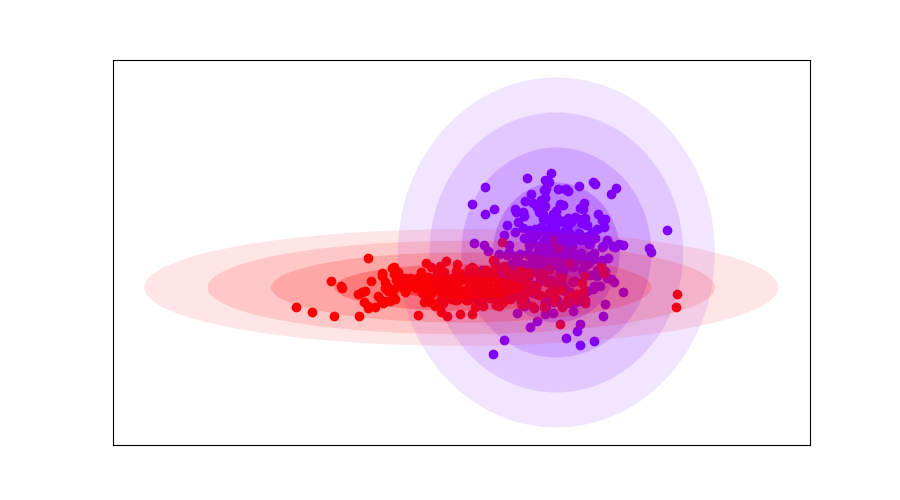

In [6]:
#Draw dummy training data
fig = plt.figure(figsize=(9, 5))
dummy.draw(named_labels=['Class 1', 'Class 2'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
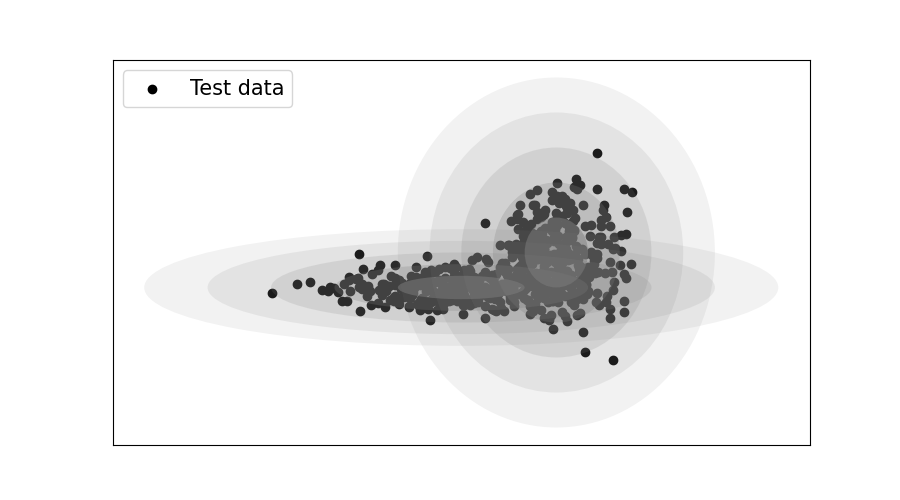

In [7]:
#Draw dummy test data
fig = plt.figure(figsize=(9, 5))
dummy_test.draw(named_labels='Test data', colors = 'black', label_wise=False)
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
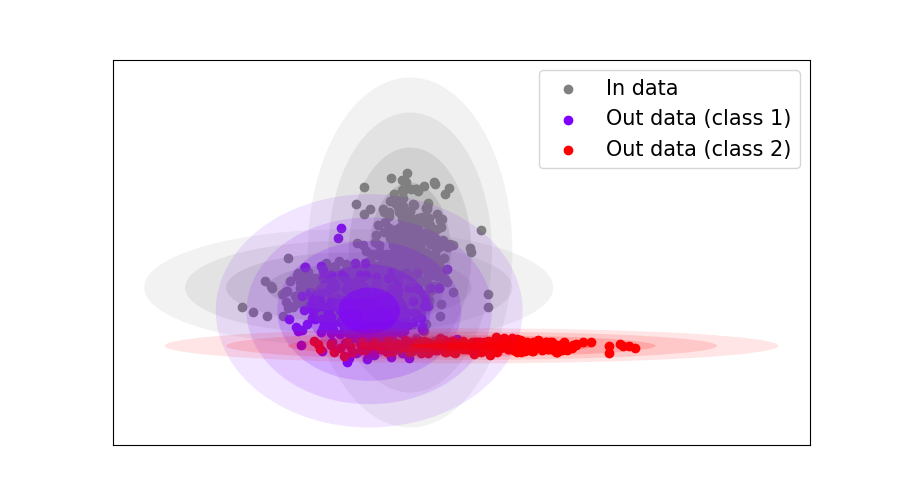

In [8]:
#Draw in-distribution and out-of-distribution dummy data
fig = plt.figure(figsize=(9, 5))

dummy.draw(label_wise=False, colors='gray',named_labels='In data')
dummy_out.draw(named_labels=['Out data (class 1)', 'Out data (class 2)'])

plt.legend()

### Train a logistic classifier

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.w = nn.Linear(2, 1)
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.out(self.w(x))
        return x
    
    def draw_decision_boundary(self, ax=None, **kwargs):
        w = list(self.parameters())
        w0 = w[0].data.cpu().numpy()
        w1 = w[1].data.cpu().numpy()
        xlim = plt.gca().get_xlim() if ax is None else ax.get_xlim()
        x_axis = np.linspace(xlim[0], xlim[1], 300)
        y_axis = -(w1[0] + x_axis*w0[0][0]) / w0[0][1]
        plt.plot(x_axis, y_axis, **kwargs)


def train(net, optimizer, criterion, data, targets):
    net.train()
    optimizer.zero_grad()
    loss = criterion(net(data), targets)
    loss.backward()
    optimizer.step()
        
        
def eval(net, data, targets, verbose=True):
    net.eval()
    y = net(data)
    pred = torch.where(y >= 0.5, torch.ones_like(y), torch.zeros_like(y))
    N_tot = len(data)
    N_correct = (pred == targets).sum().item()
    accuracy = 100*(1/N_tot)*N_correct
    if verbose:
        print('Train accuracy: {:2f} % ({} out of {})'.format(accuracy, N_correct, N_tot))
    return pred, accuracy

In [13]:
net = Net()        
optimizer = optim.SGD(net.parameters(), lr = 0.1)
criterion = nn.BCELoss()
n_epochs = 100

X = dummy.X
labels = dummy.labels

net = net.to(device)
X = X.to(device)
labels = labels.to(device) 


for epoch in range(n_epochs):
    train(net, optimizer, criterion, X, labels)
    
    if (epoch + 1) % 20 == 0 : 
        print('Epoch {}'.format(epoch + 1))
        eval(net, X, labels)

Epoch 20
Train accuracy: 64.833333 % (389 out of 600)
Epoch 40
Train accuracy: 77.000000 % (462 out of 600)
Epoch 60
Train accuracy: 82.833333 % (497 out of 600)
Epoch 80
Train accuracy: 84.666667 % (508 out of 600)
Epoch 100
Train accuracy: 86.500000 % (519 out of 600)


### Looking at the mistakes of the classifier

In [15]:
net.eval()
pred, _ = eval(net, dummy.X, labels, verbose=False)
errors = (pred != dummy.labels).type(torch.uint8)
y_correct = pred[torch.where(errors==0)[0], :]
y_incorrect = pred[torch.where(errors==1)[0], :]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
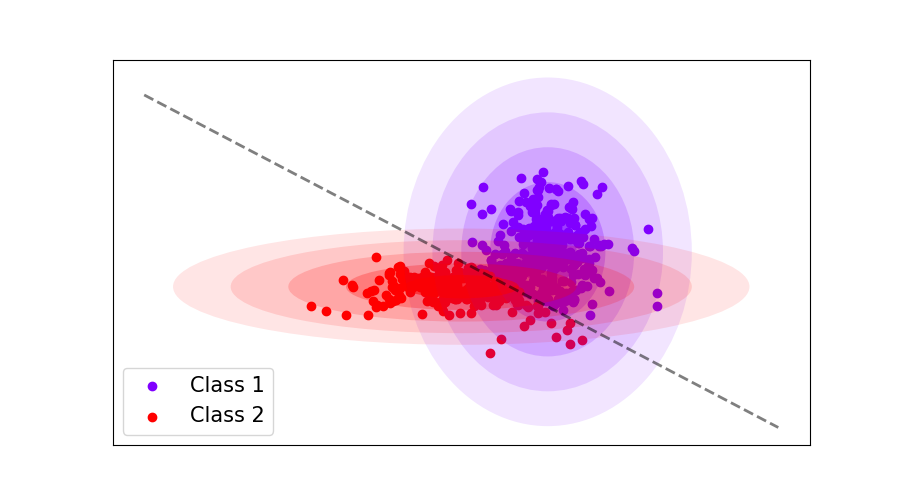

In [16]:
fig = plt.figure(figsize=(9, 5))

dummy.draw(labels=pred, named_labels=['Class 1', 'Class 2'])
net.draw_decision_boundary(color='black', linestyle='--', linewidth=2, alpha=0.5)

plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
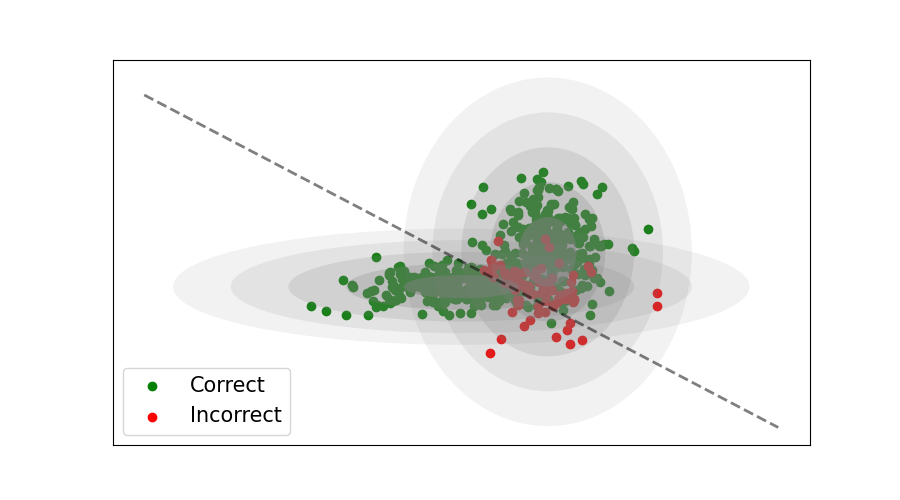

In [17]:
fig = plt.figure(figsize=(9, 5))

dummy.draw(label_wise=False, 
           labels=errors, 
           colors=['green', 'red'], 
           named_labels=['Correct', 'Incorrect']
          )

net.draw_decision_boundary(color='black', linestyle='--', linewidth=2, alpha=0.5)
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
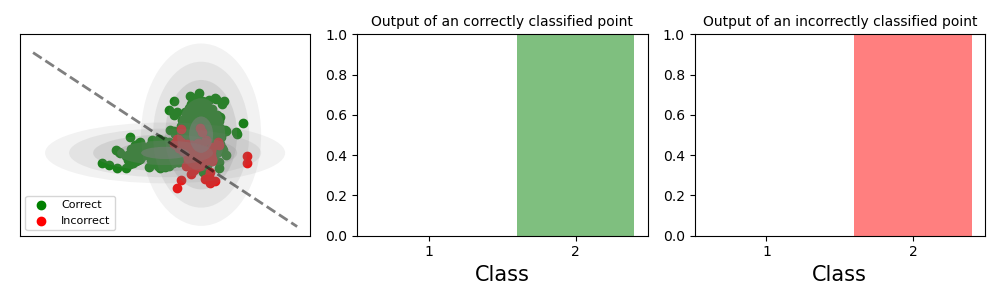

In [18]:
fig = plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
dummy.draw(label_wise=False, 
           labels=errors, 
           colors=['green', 'red'], 
           named_labels=['Correct', 'Incorrect']
          )
net.draw_decision_boundary(color='black', linestyle='--', linewidth=2, alpha=0.5)
plt.legend(prop={'size': 8})


x = 1 + np.arange(2)
plt.subplot(1, 3, 2)
ind_correct = np.random.randint(y_correct.size(0))
single_out_correct = torch.cat((y_correct[ind_correct, :], 1 - y_correct[ind_correct, :]), 0)
plt.bar(x, single_out_correct.detach().cpu().numpy(), alpha = 0.5, color = 'green')
plt.xticks(1 + np.arange(2))
plt.ylim((0, 1))
plt.xlabel('Class')
plt.title('Output of an correctly classified point', fontsize=10)


plt.subplot(1, 3, 3)
ind_incorrect = np.random.randint(y_incorrect.size(0))
single_out_incorrect = torch.cat((y_incorrect[ind_incorrect, :], 1 - y_incorrect[ind_incorrect, :]), 0)
plt.bar(x, single_out_incorrect.detach().cpu().numpy(), alpha = 0.5, color = 'red')
plt.xticks(1 + np.arange(2))
plt.ylim((0, 1))
plt.xlabel('Class')
plt.title('Output of an incorrectly classified point', fontsize=10)

plt.subplots_adjust(hspace = 0.5)
fig.tight_layout()

### Looking at out-of-distribution data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
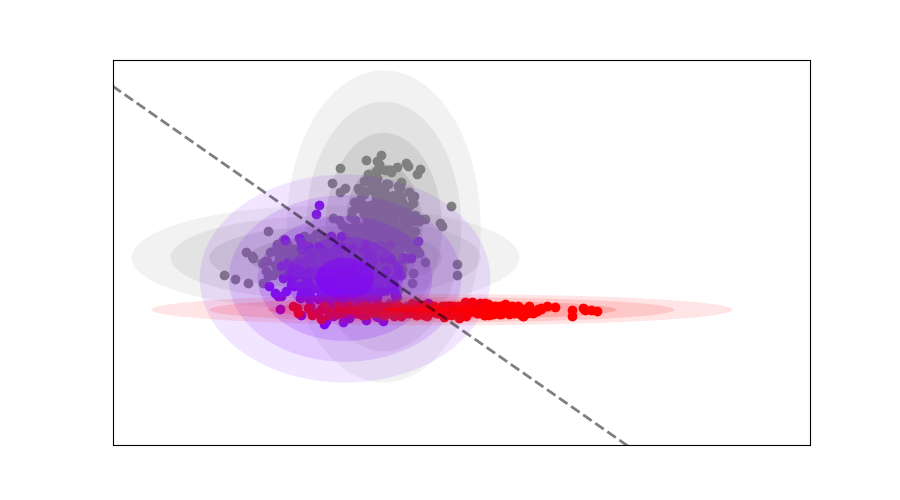

In [19]:
fig = plt.figure(figsize=(9, 5))
plt.xlim((-11, 25))
plt.ylim((-18, 19))


dummy.draw(label_wise=False, colors='gray', named_labels='In data')
dummy_out.draw()
net.draw_decision_boundary(color='black', linestyle='--', linewidth=2, alpha=0.5)

#plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
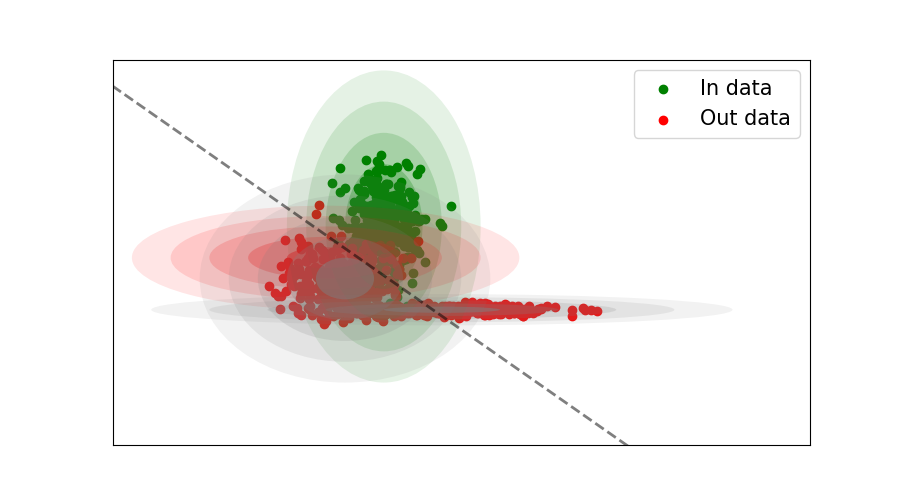

In [20]:
fig = plt.figure(figsize=(9, 5))
plt.xlim((-11, 25))
plt.ylim((-18, 19))

dummy.draw(label_wise='False', colors='green', named_labels=['In data'])
dummy_out.draw(label_wise=False, colors='red', named_labels='Out data')
net.draw_decision_boundary(color='black', linestyle='--', linewidth=2, alpha=0.5)

plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
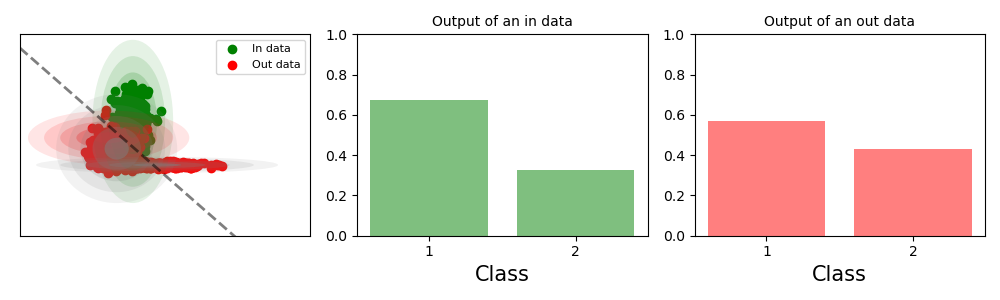

In [21]:
fig = plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)

plt.xlim((-11, 25))
plt.ylim((-18, 19))

dummy.draw(label_wise='False', colors='green', named_labels=['In data'])
dummy_out.draw(label_wise=False, colors='red', named_labels='Out data')
net.draw_decision_boundary(color='black', linestyle='--', linewidth=2, alpha=0.5)
plt.legend(prop={'size': 8})


x = 1 + np.arange(2)

plt.subplot(1, 3, 2)
net.eval()
y = net(dummy.X)
ind_in = np.random.randint(y.size(0))
single_out_in = torch.cat((y[ind_in, :], 1 - y[ind_in, :]), 0)

plt.bar(x, single_out_in.detach().cpu().numpy(), alpha = 0.5, color = 'green')
plt.xticks(1 + np.arange(2))
plt.ylim((0, 1))
plt.xlabel('Class')
plt.title('Output of an in data', fontsize=10)


plt.subplot(1, 3, 3)
net.eval()
y_out = net(dummy_out.X)
ind_out = np.random.randint(y_out.size(0))
single_out_out = torch.cat((y_out[ind_out, :], 1 - y_out[ind_out, :]), 0)
plt.bar(x, single_out_out.detach().cpu().numpy(), alpha = 0.5, color = 'red')
plt.xticks(1 + np.arange(2))
plt.ylim((0, 1))
plt.xlabel('Class')
plt.title('Output of an out data', fontsize=10)

plt.subplots_adjust(hspace = 0.5)
fig.tight_layout()

# Image classification

### Load DenseNet-10 pre-trained on CIFAR-10 (in dataset) and ImageNet (out dataset)

In [22]:
nn_name = "densenet10"
in_dataset_name = "CIFAR10"
out_dataset_name = "Imagenet_resize"

batch_size = 128
gpu = None
#gpu=0
#device = torch.device("cuda:0")

#Load model
#model = dl.load_pre_trained_nn(nn_name, gpu)
model = load_pre_trained_nn(nn_name, gpu)

#Load in-distribution test data
#in_dataloader = dl.test_dataloader(in_dataset_name, transform_name=in_dataset_name, batch_size=batch_size)
in_dataloader = test_dataloader(in_dataset_name, transform_name=in_dataset_name, batch_size=batch_size)


#Load out-distribution test data
#out_dataloader = dl.test_dataloader(out_dataset_name, in_dataset_name, batch_size=batch_size)
out_dataloader = test_dataloader(out_dataset_name, in_dataset_name, batch_size=batch_size)

[INFO] data_and_nn_loader - model /u/mernoult/ESIEE_class/pre_trained/densenet10.pth loaded
/u/mernoult/.conda/envs/doctor/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'densenet.DenseNet3' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/u/mernoult/.conda/envs/doctor/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/u/mernoult/.conda/envs/doctor/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'densen

Files already downloaded and verified


[INFO] data_and_nn_loader - dataset CIFAR10 loaded with batch size 128
[INFO] data_and_nn_loader - dataset Imagenet_resize loaded with batch size 128


### Defining Out-of-Distribution scores

In [37]:
#Define different scores
def msp(logits, *args, **kwargs):
    return torch.max(F.softmax(logits, dim=1), dim=1)[0]


def odin(logits, *args, **kwargs):
    
    temperature=kwargs['T'] if 'T' in kwargs else 1
    
    return torch.max(F.softmax(logits / temperature, dim=1), dim=1)[0]


def energy(logits, temperature, *args, **kwargs):
    return temperature * torch.log(torch.sum(torch.exp(logits / temperature), dim=1))

# Example: Maximum Softmax Probability (MSP)

### Intuition

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
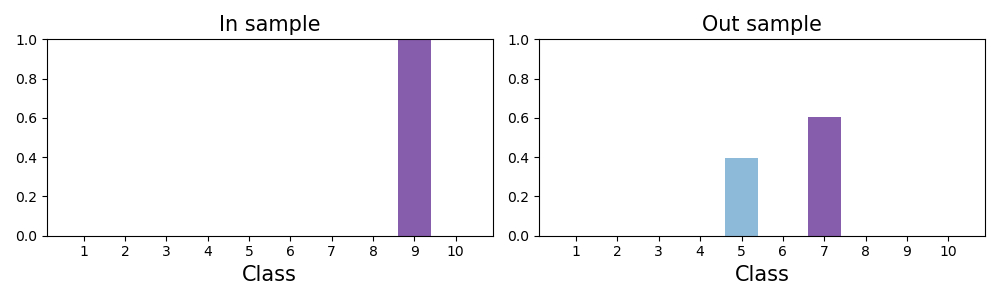

In [25]:
_, (x_in, _) = next(enumerate(in_dataloader))
_, (x_out, _) = next(enumerate(out_dataloader))

with torch.no_grad():
    x_in = x_in.to(device)
    x_out = x_out.to(device)
    logits_in = model(x_in)
    logits_out = model(x_out)
    y_in = F.softmax(logits_in, dim=1)
    y_out = F.softmax(logits_out, dim=1)

ind = np.random.randint(y_in.size(0))

x = 1 + np.arange(y_in[ind, :].size(0))

fig = plt.figure(figsize = (10, 3))
plt.subplot(1, 2, 1)
_, max_in = torch.max(y_in[ind, :], 0)

plt.bar(x, y_in[ind, :].detach().cpu().numpy(), alpha = 0.5)
plt.bar((max_in + 1).cpu().numpy(), y_in[ind, max_in].detach().cpu().numpy(), alpha = 0.5, color = 'purple')

plt.xticks(1 + np.arange(10))
plt.ylim((0, 1))
plt.title('In sample', fontsize=15)
plt.xlabel('Class')

plt.subplot(1, 2, 2)
_, max_out = torch.max(y_out[ind, :], 0)

plt.bar(x, y_out[ind, :].detach().cpu().numpy(), alpha = 0.5)
plt.bar((max_out + 1).cpu().numpy(), y_out[ind, max_out].detach().cpu().numpy(), alpha = 0.5, color = 'purple')

plt.xticks(1 + np.arange(10))
plt.ylim((0, 1))
plt.title('Out sample', fontsize=15)
plt.xlabel('Class')
plt.tight_layout()

### Compute scores

In [26]:
def compute_odd_scores(model, func, in_dataloader, out_dataloader, requires_grad=False, **kwargs):
    
    if not requires_grad:
        with torch.no_grad():
            scores_in = []
            for _, (x_in, _) in enumerate(in_dataloader):
                x_in = x_in.to(device)
                scores_in += func(model(x_in), **kwargs)

            scores_in = torch.vstack(scores_in).squeeze(1).cpu().numpy()

            scores_out = []
            for _, (x_out, _) in enumerate(out_dataloader):
                x_out = x_out.to(device)
                scores_out += func(model(x_out), **kwargs)
            scores_out = torch.vstack(scores_out).squeeze(1).cpu().numpy()
    
    else:
        eps = kwargs['eps']
        scores_in = []
        for _, (x_in, _) in enumerate(in_dataloader):
            x_in = x_in.to(device)
            x_in.requires_grad = True
            scores_tmp = func(model(x_in), **kwargs)
            init_grad = torch.tensor([1 for i in range(scores_tmp.size(0))], dtype=torch.float, device=device, requires_grad=True)
            grad = torch.autograd.grad(scores_tmp, x_in, grad_outputs=init_grad, retain_graph = True)[0]
            x_pert = (x_in + eps*torch.sign(grad)).detach()
            scores_in += func(model(x_pert), **kwargs).detach()
            

        scores_in = torch.vstack(scores_in).squeeze(1).cpu().numpy()

        scores_out = []
        for _, (x_out, _) in enumerate(out_dataloader):
            x_out = x_out.to(device)
            x_out.requires_grad = True
            scores_tmp = func(model(x_out), **kwargs)
            init_grad = torch.tensor([1 for i in range(scores_tmp.size(0))], dtype=torch.float, device=device, requires_grad=True)
            grad = torch.autograd.grad(scores_tmp, x_out, grad_outputs=init_grad, retain_graph = True)[0]
            x_pert = (x_out + eps*torch.sign(grad)).detach()
            scores_out += func(model(x_pert), **kwargs).detach()
            
        scores_out = torch.vstack(scores_out).squeeze(1).cpu().numpy()        

    return scores_in, scores_out

In [27]:
#Compute scores over the whole test in-distribution and out-of-distribution sets
scores_in, scores_out = compute_odd_scores(model, msp, in_dataloader, out_dataloader)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
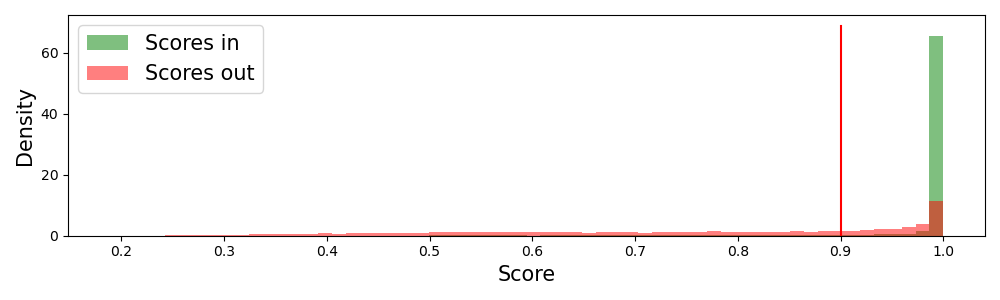

In [28]:
#Plot the resulting histograms

fig = plt.figure(figsize = (10, 3))

bins=np.histogram(np.hstack((scores_in, scores_out)), bins=60)[1]
plt.hist(scores_in, bins, alpha=0.5, label = 'Scores in', density=True, color='green')
plt.hist(scores_out, bins, alpha=0.5, label = 'Scores out', density=True, color='red')

thr=0.9
ylim = plt.gca().get_ylim()
plt.plot(thr*np.ones(300), np.linspace(0, ylim[1], 300), color='red')

plt.ylabel('Density')
plt.xlabel('Score')
plt.legend(loc='best')
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
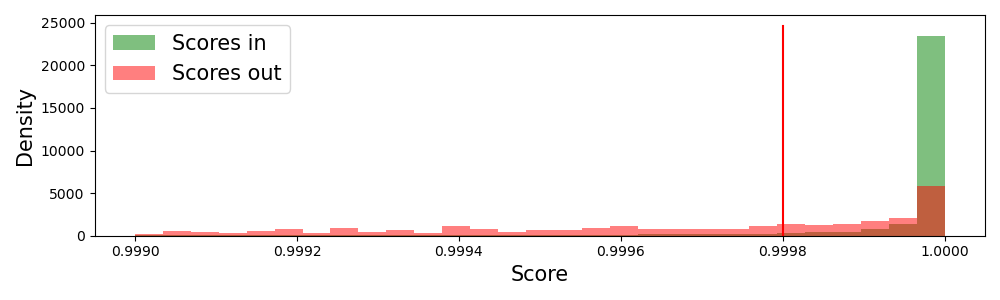

In [29]:
fig = plt.figure(figsize = (10, 3))

plt.hist(scores_in, alpha=0.5, bins=list(np.linspace(0.999, 1, 30)), label = 'Scores in', color='green', density=True)
plt.hist(scores_out, alpha=0.5, bins=list(np.linspace(0.999, 1, 30)), label = 'Scores out', color='red', density=True)

thr=0.9998
ylim = plt.gca().get_ylim()
plt.plot(thr*np.ones(300), np.linspace(0, ylim[1], 300), color='red')

plt.ylabel('Density')
plt.xlabel('Score')
plt.legend(loc='best')
fig.tight_layout()

### Threshold calibration

In [30]:
def compute_metrics(scores_in, scores_out, verbose=True):
    #Plot TPR-FPR and P-R curves
    pos = np.ones(len(scores_in))
    neg = np.zeros(len(scores_out))
    y_true = np.concatenate([pos, neg]).reshape(-1)
    y_pred = np.concatenate([scores_in, scores_out]).reshape(-1)

    #Compute FP and TP rates for varying thresholds
    fprs, tprs, thresholds = skm.roc_curve(y_true, y_pred, pos_label=1)  # fpr: s > thr

    #Compute precision and recall for varying thresholds
    prs = tprs[1:]/(fprs[1:] + tprs[1:])
    rcls = tprs[1:]
    
    #Compute FPR at TPR = 0.95
    TPR=0.95
    FPR_AT_TPR = np.interp(TPR, tprs, fprs)
    
    #Compute AUROC
    auroc = np.trapz(tprs, fprs)

    #Compute AUPR
    aupr = skm.average_precision_score(y_true, y_pred)

    #Compute detection error
    detection_error = 0.5*FPR_AT_TPR + 0.5*(1 - TPR)
    
    
    if verbose:
        print('FPR at TPR=0.95: {:.2f}'.format(FPR_AT_TPR))
        print('AUROC: {:.2f}'.format(auroc))
        print('AUPR: {:.2f}'.format(aupr))
        print('Detection error: {:.2f}'.format(detection_error))
        
    
    metrics = {}
    metrics['fprs'] = fprs
    metrics['tprs'] = tprs
    metrics['thresholds'] = thresholds
    metrics['rcls'] = rcls
    metrics['prs'] = prs
    
    metrics['TPR'] = TPR
    metrics['FPR_AT_TPR'] = FPR_AT_TPR
    metrics['auroc'] = auroc
    metrics['aupr'] = aupr
    metrics['detection_error'] = detection_error
    
    return metrics

def animation_ROC_PR(scores_in, scores_out):
    
    metrics = compute_metrics(scores_in, scores_out)
    fprs, tprs, thresholds, rcls, prs = metrics['fprs'], metrics['tprs'], metrics['thresholds'], metrics['rcls'], metrics['prs']
    
    ind = 1
    ax1 = fig.add_subplot(1,3,1)
    thr = thresholds[ind]
    bins=np.histogram(np.hstack((scores_in, scores_out)), bins=60)[1]
    plt.hist(scores_in, bins, alpha=0.5, label = 'Scores in', color='green', density=True)
    plt.hist(scores_out, bins, alpha=0.5, label = 'Scores out', color='red', density=True)

    ylim = plt.gca().get_ylim()

    line1, = ax1.plot(thr*np.ones(300), np.linspace(0, ylim[1], 300), color='red')

    ax2 = fig.add_subplot(1, 3, 2)
    plt.plot(fprs, tprs, linewidth=3, alpha=0.8)

    line2 = ax2.scatter(fprs[ind], tprs[ind], color = 'red', s=60)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim((0, 1.05))
    plt.xlim((-0.05, 1.05))
    plt.title('ROC curve', fontsize=20)
    plt.grid()

    ax3 = fig.add_subplot(1, 3, 3)
    plt.plot(rcls, prs, linewidth=3, alpha=0.8)

    line3 = ax3.scatter(rcls[ind], prs[ind], color = 'red', s=60)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim((0, 1.05))
    plt.title('PR curve', fontsize=20)
    plt.grid()

    plt.subplots_adjust(hspace = 0.5)
    fig.tight_layout()


    def update(ind = 1):
        line1.set_xdata(thresholds[ind]*np.ones(300))

        line2.set_offsets((fprs[ind], tprs[ind]))

        line3.set_offsets((rcls[ind], prs[ind]))

        fig.canvas.draw_idle()

    interact(update,ind=(1, len(thresholds) - 2));

In [31]:
#Plot TPR-FPR and P-R curves
metrics = compute_metrics(scores_in, scores_out)

FPR at TPR=0.95: 0.41
AUROC: 0.94
AUPR: 0.95
Detection error: 0.23


FPR at TPR=0.95: 0.41
AUROC: 0.94
AUPR: 0.95
Detection error: 0.23


interactive(children=(IntSlider(value=1, description='ind', max=3859, min=1), Output()), _dom_classes=('widget…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
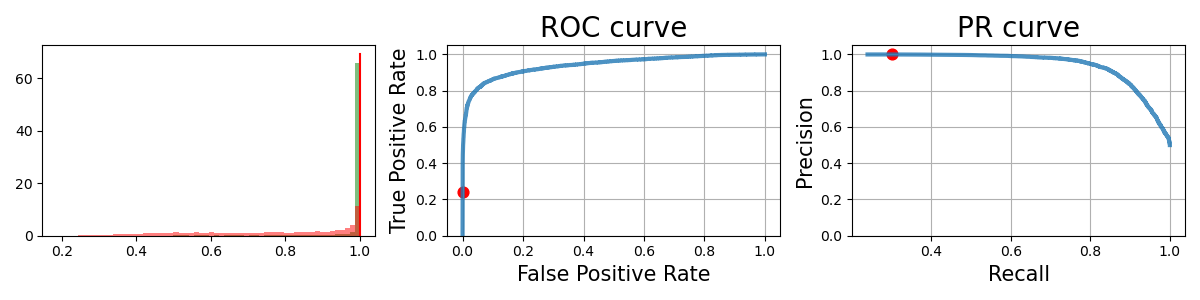

In [32]:
fig = plt.figure(figsize=(12, 3))
animation_ROC_PR(scores_in, scores_out)

### Understand the evaluation metrics

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
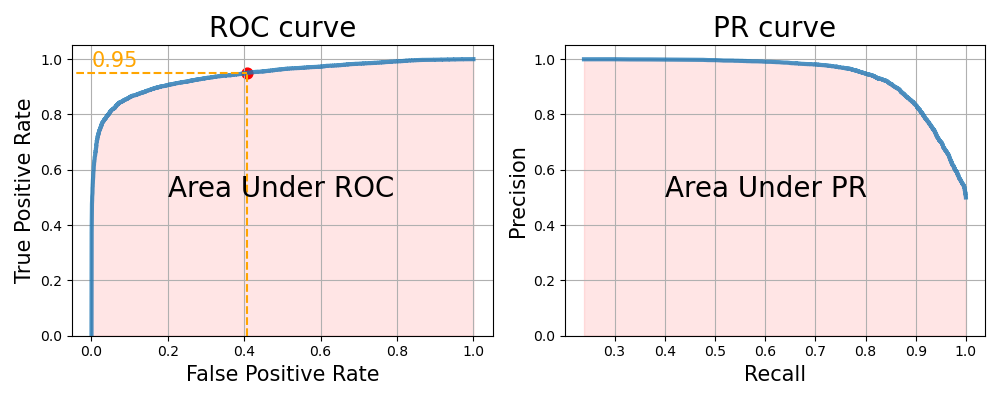

In [34]:
TPR, FPR_AT_TPR = metrics['TPR'], metrics['FPR_AT_TPR']
fprs = metrics['fprs']
tprs = metrics['tprs']
thresholds = metrics['thresholds']
rcls = metrics['rcls']
prs = metrics['prs']


fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fprs, tprs, linewidth=3, alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fprs, tprs, y2=0, alpha = 0.1, color='red')
plt.text(0.2, 0.5, 'Area Under ROC', fontsize=20)

ax = plt.gca()
ax.scatter(FPR_AT_TPR, TPR, color = 'red', s=60)
plt.plot(FPR_AT_TPR*np.ones(300), np.linspace(0, TPR, 300), linestyle='--', color='orange')
plt.plot(np.linspace(-1, FPR_AT_TPR, 300), TPR*np.ones(300), linestyle='--', color='orange')
plt.text(0, TPR + 0.02, str(TPR), fontsize=15, color='orange')

plt.ylim((0, 1.05))
plt.xlim((-0.05, 1.05))
plt.title('ROC curve', fontsize=20)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(rcls, prs, linewidth=3, alpha=0.8)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.fill_between(rcls, prs, y2=0, alpha = 0.1, color='red')
plt.text(0.4, 0.5, 'Area Under PR', fontsize=20)
plt.ylim((0, 1.05))
plt.title('PR curve', fontsize=20)
plt.grid()

plt.subplots_adjust(hspace = 0.5)
fig.tight_layout()

# Error Detection: DOCTOR

In [ ]:
with torch.no_grad():
    scores_true = []
    scores_false = []
    for _, (x,t) in enumerate(in_dataloader):
        x, t = x.to(device), t.to(device)
        logits= model(x)
        y = F.softmax(logits, dim=1)
        values, inds = torch.max(y, 1)
        scores_true += 1 - values[inds == t]
        scores_false += 1 - values[inds != t]

In [ ]:
scores_true = torch.vstack(scores_true).squeeze(1).cpu().numpy()
scores_false = torch.vstack(scores_false).squeeze(1).cpu().numpy()

fig = plt.figure(figsize = (10, 3))

bins=np.histogram(np.hstack((scores_true, scores_false)), bins=60)[1]
plt.hist(scores_true, bins, alpha=0.5, label = 'Scores correct', density=True, color='green')
plt.hist(scores_false, bins, alpha=0.5, label = 'Scores incorrect', density=True, color='red')

plt.ylabel('Density')
plt.xlabel('Score')
plt.legend(loc='best')
fig.tight_layout()

In [ ]:
#Plot TPR-FPR and P-R curves
metrics = compute_metrics(-scores_true, -scores_false)

In [ ]:
fig = plt.figure(figsize=(12, 3))
animation_ROC_PR(-scores_true, -scores_false)

# ODIN

### Effect of input pre-processing and temperature scaling

In [35]:
_, (x, _) = next(enumerate(in_dataloader))
x = x.to(device)
x.requires_grad=True
logits_tmp = model(x)
scores = odin(logits_tmp)

KeyError: 'T'

In [36]:
scores_in, scores_out = compute_odd_scores(model, odin, in_dataloader, out_dataloader, requires_grad=True, T=1000, eps=0.0014)

In [38]:
#Plot TPR-FPR and P-R curves
metrics = compute_metrics(scores_in, scores_out)

FPR at TPR=0.95: 0.11
AUROC: 0.98
AUPR: 0.98
Detection error: 0.08


FPR at TPR=0.95: 0.11
AUROC: 0.98
AUPR: 0.98
Detection error: 0.08


interactive(children=(IntSlider(value=1, description='ind', max=3737, min=1), Output()), _dom_classes=('widget…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
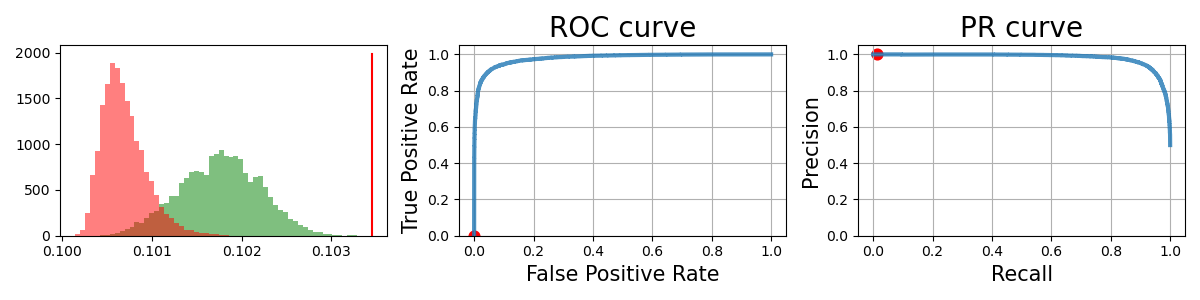

In [39]:
fig = plt.figure(figsize=(12, 3))
animation_ROC_PR(scores_in, scores_out)

# Mahalanobis distance-based OOD

### Compute logits for in-distribution and out-of-distribution data

In [ ]:
with torch.no_grad():
    
    logits = []
    labels = []
    for _, (x, _) in enumerate(in_dataloader):
        x = x.to(device)
        logits_tmp = model(x)
        logits += logits_tmp
        _, labels_tmp = torch.max(logits_tmp, 1)
        labels += labels_tmp

    logits = torch.vstack(logits)
    labels = torch.vstack(labels)

In [ ]:
with torch.no_grad():
    
    '''
    _, (x_out, _) = next(enumerate(out_dataloader))
    x_out = x_out.to(device)
    logits_out = model(x_out)
    '''
    
    logits_out = []
    
    for _, (x_out, _) in enumerate(out_dataloader):
        x_out = x_out.to(device)
        logits_tmp = model(x_out)
        logits_out += logits_tmp

    logits_out = torch.vstack(logits_out)

### Perform dimensionality reduction with t-SNE for visualization

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
logits_compressed = torch.tensor(tsne.fit_transform(torch.cat((logits, logits_out),0).cpu().detach().numpy()))

### Compute Gaussian parameters in 2D

In [ ]:
mus2d = []
covs2d = []
logits_compressed_in = logits_compressed[:-logits_out.size(0)]

for l in range(10):
    logits_tmp = logits_compressed_in[torch.where(labels==l)[0], :]
    mu_tmp = logits_tmp.mean(0)
    mus2d += [mu_tmp]
    covs2d += [((logits_tmp - mu_tmp.unsqueeze(0).repeat(logits_tmp.size(0), 1))**2).mean(0)]
    
mus2d = torch.vstack(mus2d)
covs2d = torch.vstack(covs2d)

### Draw embeddings in 2D

In [ ]:
fig = plt.figure(figsize=(9, 5))

ulabels, colors = scatter(logits_compressed_in, labels=labels, s=3,
                         named_labels=['Class '+ str(l) for l in range(10)])

'''
for l in range(10):
    draw_ellipse(mus2d[l], torch.diag(covs2d[l]), fc = colors[l])
'''

logits_compressed_out = logits_compressed[-logits_out.size(0):]

#scatter(logits_compressed_out, s=3, colors = 'black', named_labels='Out')

plt.ylim((-115, 110))
plt.xlim((-100, 110))
plt.legend(loc = 'lower left', prop={'size': 10})

### Compute Gaussian parameters in the logits space

In [ ]:
mus = []
covs = []

for l in range(10):
    logits_tmp = logits[torch.where(labels==l)[0], :]
    mu_tmp = logits_tmp.mean(0)
    mus += [mu_tmp]
    covs += [((logits_tmp - mu_tmp.unsqueeze(0).repeat(logits_tmp.size(0), 1))**2).mean(0)]
    
mus = torch.vstack(mus)
covs = torch.vstack(covs)
inv_covs = 1/covs

### Compute Mahalanobis score for in and out samples

In [ ]:
def mahalanobis_score_diag(logits, **kwargs):
    mus = kwargs['mus']
    inv_covs = kwargs['inv_covs']
    X = logits.unsqueeze(-1).repeat(1, 1, logits.size(1))
    MU = mus.t().unsqueeze(0).repeat(logits.size(0), 1, 1)
    INV_COV = inv_covs.t().unsqueeze(0).repeat(logits.size(0), 1, 1)
    D, _ = torch.min((INV_COV*(X - MU)**2).sum(1), 1)
    return -D

In [ ]:
#mahalanobis_score_diag(logits_tmp, mus=mus, inv_covs=inv_covs)
scores_in, scores_out = compute_odd_scores(model, mahalanobis_score_diag, in_dataloader, out_dataloader, mus=mus, inv_covs=inv_covs)

In [ ]:
#Plot TPR-FPR and P-R curves
metrics = compute_metrics(scores_in, scores_out)

In [ ]:
fig = plt.figure(figsize=(12, 3))
animation_ROC_PR(scores_in, scores_out)

### Same but with input pre-processing

In [ ]:
scores_in, scores_out = compute_odd_scores(model, mahalanobis_score_diag, in_dataloader, out_dataloader, mus=mus, inv_covs=inv_covs, requires_grad=True, eps=0.012)

In [ ]:
#Plot TPR-FPR and P-R curves
metrics = compute_metrics(scores_in, scores_out)

In [ ]:
fig = plt.figure(figsize=(12, 3))
animation_ROC_PR(scores_in, scores_out)